# <center> Homework 3: Problem 1 </center>
#### <center> Anxhelo Xhebraj xhebraj.1643777@studenti.uniroma1.it </center>
#### <center> {25 Nov .. 9 Dec} 2018 </center>

In [1]:
%load_ext blackcellmagic
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ipywidgets as widgets
import numpy as np

np.seterr(divide="ignore", invalid="ignore")

from IPython.display import Image

from ipywidgets import interact

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import davies_bouldin_score, silhouette_score

from spherecluster import SphericalKMeans

from collections import Counter

seed = 42

## Dataset to Tf-Idf vectors
We use the `preprocessed_announcements.tsv` of the last homework which contains for each line the normalized tokens of the corresponding document. The Tf-Idf vectorizer will produce the normalized representation of the documents.

In [3]:
tfidf_vec = TfidfVectorizer(lowercase=False)

X = None
with open("../data/preprocessed_announcements.tsv") as f:
    X = tfidf_vec.fit_transform(f.readlines())

dense_X = X.toarray()

### 2D SVD projection of the vectors
We visualize the dataset projecting it into 2D through SVD. Given the linearity of the projection and the high dimensionality of the tfidf representation it is possible to spot outliers and have an overview of the dataset.

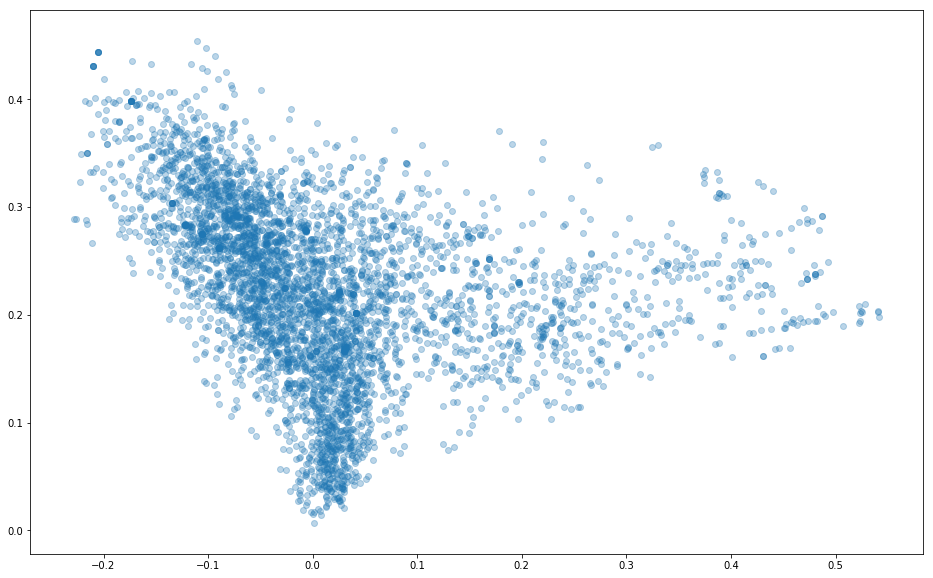

In [4]:
X_2 = TruncatedSVD(n_components=2, random_state=seed).fit_transform(dense_X)
plt.figure(figsize=(16, 10))
plt.scatter(X_2[:, 1], X_2[:, 0], alpha=0.3)
plt.show()

## Perform Spherical KMeans for multiple $k$ s

In order to perform clustering using cosine distance as a distance metric we can use a *Spherical KMeans* implementation of which algorithm is similar to KMeans except in that Spherical KMeans normalizes the centers found after the expectation step. This is similar to using the cosine distance as cost function when vectors are normalized.

The algorithm is run for multiple values of $k$ to later choose which of them provides a satisfactory result.

When choosing $k$ we should take into consideration the size of the dataset ($4424$ items), the diversity of the documents (which can be considered scarce given the fact that documents belong to the same category on kijiji) and the presence of near duplicates (amounting $\approx 36.1\%$ of the documents as inferred in the previous homework). Although duplicates could have been removed we chose not to do so by the fact that such information can provide a hint, maybe superficial, over the goodness of the clusters.

In [ ]:
davies_scores = []
silhouette_scores = []
for k in range(2, 100, 3):
    skm = SphericalKMeans(n_clusters=k, random_state=seed).fit(X)
    plt.figure(figsize=(16, 10))
    plt.scatter(X_2[:, 1], X_2[:, 0], alpha=0.2, c=skm.labels_)
    davies_scores.append(davies_bouldin_score(dense_X, skm.labels_))
    silhouette_scores.append(silhouette_score(dense_X, skm.labels_, random_state=seed, metric="cosine"))
    plt.savefig('images/svd' + str(k // 3 + 1) + '.png')

print(davies_scores)
print(silhouette_scores)

In [ ]:
plt.figure(figsize=(10, 3))
k = [i for i in range(2,100,3)]
plt.plot(k, davies_scores)

plt.xlabel('k', fontsize=16)
plt.ylabel('davies_score', fontsize=16)

plt.figure(figsize=(10,3))
plt.plot(k, silhouette_scores, color='orange')
plt.xlabel('k', fontsize=16)
plt.ylabel('silhouette_score', fontsize=16)

The *Davies-Bouldin* score significantly drops up to $k = 16$ and then continues decreasing at a lower rate suggesting $k$ to be lower than 20 while the silhouette score just shows a steady increase in value as $k$ grows.

In [ ]:
def g(k):
    print("\rdavies_bouldin_score:", davies_scores[k["new"] // 3], end="")


def f(k):
    return Image(filename="./images/svd" + str(k // 3 + 1) + ".png")


inp = widgets.IntSlider(min=2, max=100, step=3, value=1)
interact(f, k=inp)
print("davies_bouldin_score:", davies_scores[0], end="")
inp.observe(g, "value")


## Observe clusters for $k = 16$

In order to evaluate the clusters produced we take the top scoring dimensions according to TfIdf for each center of each cluster.

In [5]:
k = 16
skm = SphericalKMeans(n_clusters=k, random_state=seed).fit(X)
centroids = skm.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vec.get_feature_names()
sizes = Counter(skm.labels_)
for i in range(k):
    print("Cluster {} (size {}):".format(i,sizes[i]), end='')
    for ind in centroids[i, :20]:
        print(' {}'.format(terms[ind]), end='')
    print()

Cluster 0 (size 273): con per dei conoscenza roma dati milano del personali esperienza della autorizzazione trattamento lâ sensi lavoro 196 java lgs offerta
Cluster 1 (size 683): conoscenza del sviluppo per software con dei della programmatore esperienza una lavoro capacità php nel informatica team che delle ambito
Cluster 2 (size 144): and f2 dalla sia relatech servizi dei informatica f2informatica the territorio dal per milano opera soluzioni corsico sede propri nell
Cluster 3 (size 366): candidatura per inviarci clicca sottostante tua link vedi modalità sito sul web tecnico inviare con informatico nel azienda esperienza settore
Cluster 4 (size 104): management movia realtà come spa facility decennio crede investe competitiva fornitore articolata velocemente ampia proponendosi espressa flessibile strutturata gamma momento
Cluster 5 (size 100): edit data roma proconsul milano oracle all per art esclusivamente sono indicate dati riferimento commerciale cui group candidati 13 conservati

In [30]:
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

X_2 = TSNE(perplexity=20, n_iter=1200).fit_transform(normalize(TruncatedSVD(n_components=50, random_state=seed).fit_transform(X)))

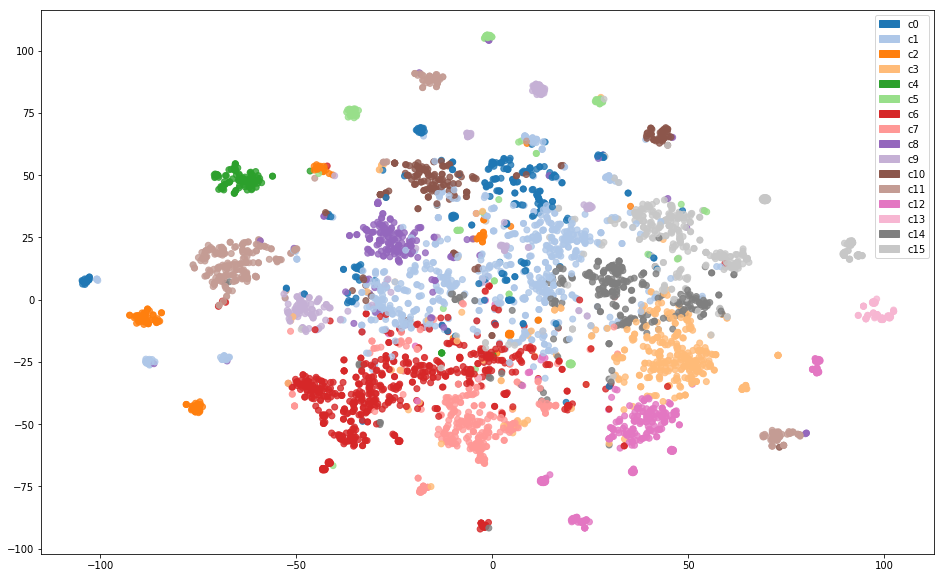

In [37]:
col = lambda x: plt.get_cmap('tab20')(x * 2) 

plt.figure(figsize=(16, 10))
plt.scatter(X_2[:, 1], X_2[:, 0], c=[plt.get_cmap('tab20')(l) for l in skm.labels_], alpha=0.8, cmap=plt.get_cmap('tab20'))

patches = []
for i in set(skm.labels_):
    patches.append(mpatches.Patch(color=plt.get_cmap('tab20')(i), label='c'+str(i)))
    
plt.legend(handles=patches)
plt.show()